In [1]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import statsmodels.api as sm
import os
import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

kad_utils.customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython']


# Reading data

In [2]:
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"
file_name = "artificialWithAnomaly/art_daily_flatmiddle.csv"
# file_dir = "artificialWithAnomaly"
# file_name = "artificialWithAnomaly/art_daily_jumpsup.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df.resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

# Data preprocessing

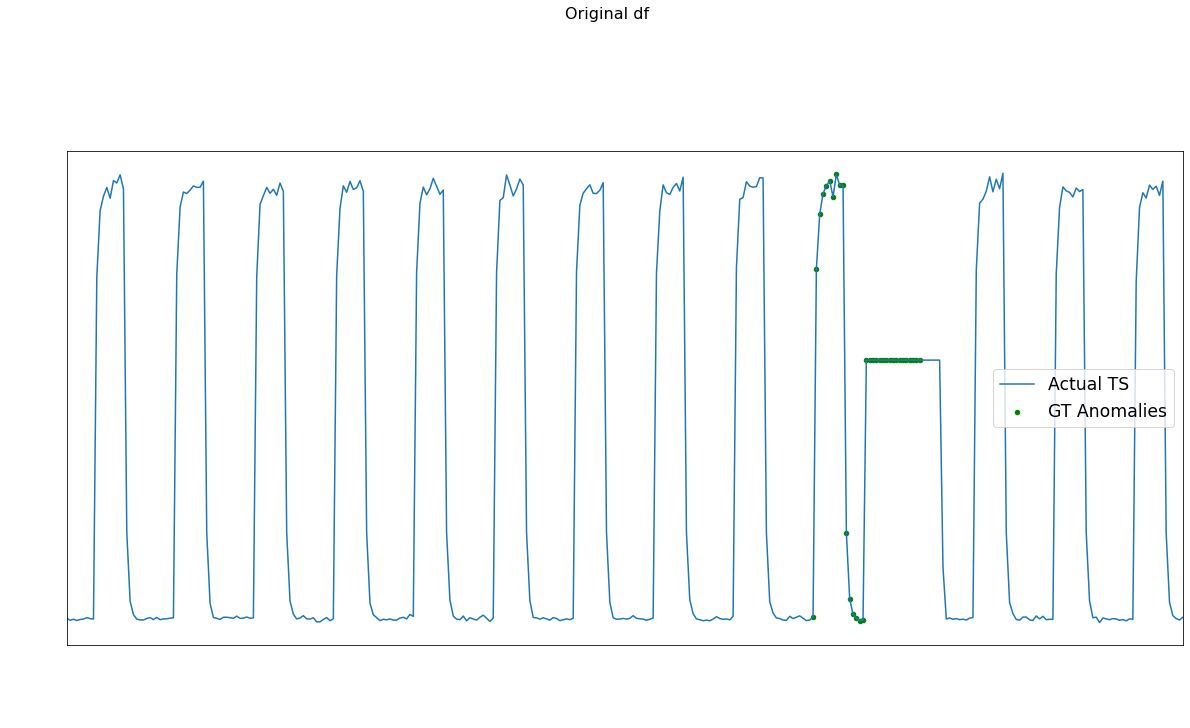

In [3]:
X_LABEL = "timestamp"

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")

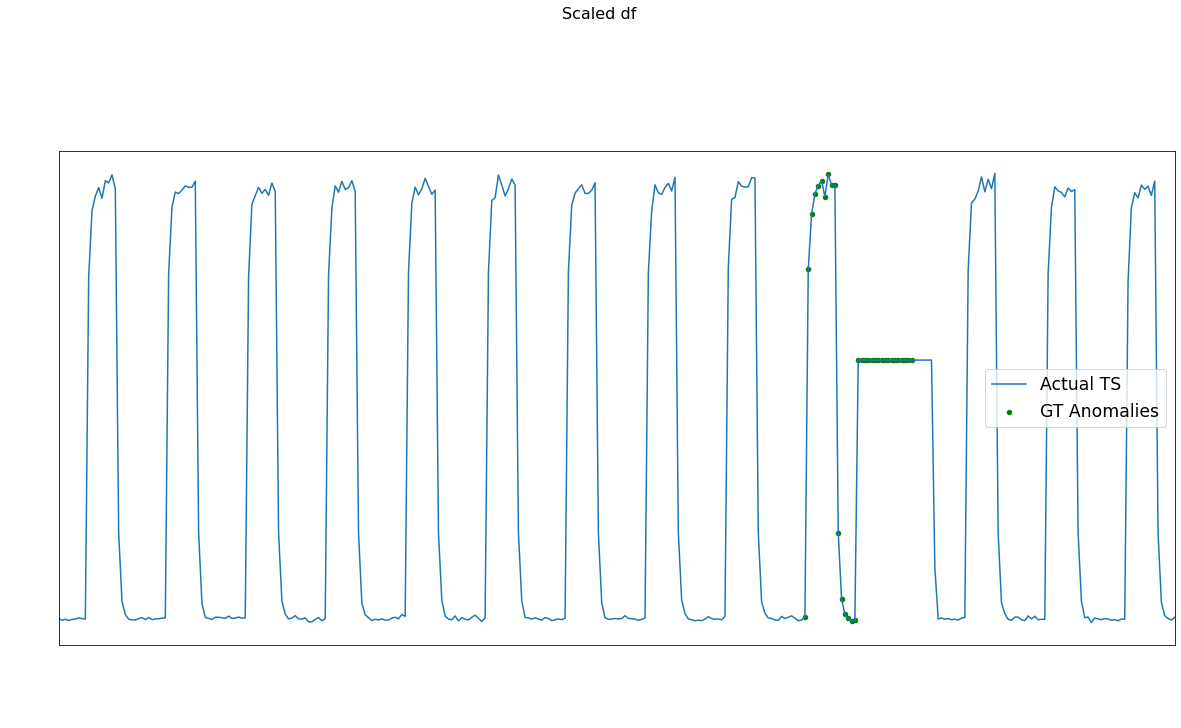

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")

In [14]:
anomaly_window = preprocessed_df[preprocessed_df["gt_is_anomaly"]]
anomaly_window_start = anomaly_window.iloc[0]
anomaly_window_middle = anomaly_window.iloc[int(len(anomaly_window)/2)]
anomaly_window_end = anomaly_window.iloc[-1]

In [31]:
temp_df = preprocessed_df.reset_index()

In [36]:
anom_idx = temp_df.index[temp_df["timestamp"] == anomaly_window_middle.name]

In [37]:
temp_df.iloc[anom_idx]


,timestamp,value,gt_is_anomaly
240,2014-04-11,0.584146,True


# Anomaly scoring components

- 0.5 - distance between the actual anomaly and the closest alert / anomaly window (rewards true positives, punishes true negatives)
- max(1, area under (true positives rewarding function AND anomaly score/label)) (rewards true positives, punishes true negatives + continuous anomalies)
- 1 + area under (false positives punishing function AND anomaly score/label)) (rewards false negatives, punishes false positives)
